In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from typing import *
import mne
import scipy as sp
from abc import ABC, abstractmethod
from alltools.machine_learning.designer import *
import pickle
from sklearn.model_selection import train_test_split

2022-06-10 11:22:44.559438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 11:22:44.559464: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
def compute_morlet_cwt(sig: np.ndarray, t: np.ndarray, freqs: np.ndarray, omega_0: Optional[float] = 5, phase: Optional[bool] = False) -> np.ndarray:
    dt = t[1] - t[0]
    widths = omega_0 / (2 * np.pi * freqs * dt)
    morlet = lambda M, s: signal.morlet2(M, s, w=omega_0)
    cwtmatr = signal.cwt(sig, morlet, widths)
    if phase:
        return cwtmatr
    else:
        return np.real(cwtmatr)**2 + np.imag(cwtmatr)**2


def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplespacing=1):
    freqs = np.abs(np.fft.fftfreq(samples, samplespacing))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

def normal_rows(matr):
    matr_n = matr.copy()

    for i, row in enumerate(matr):
        matr_n[i] /= row.mean()

    return matr_n


def random_walk(x):
    out = []
    start=0
    for _ in x:
        step = np.random.uniform(-1,1)
        # print(step)
        start = start + step
        out.append(start)

    return np.array(out)


def read_pkl(path: str) -> Any:
    with open(
        path,
        'rb'
    ) as file:
        content = pickle.load(
            file
        )
    return content


def save_pkl(content: Any, path: str) -> NoReturn:
    if path[-4:] != '.pkl':
        raise OSError(f'Pickle file must have extension ".pkl", but it has "{path[-4:]}"')

    pickle.dump(content, open(path, 'wb'))


def plot_data_sample(X, P, Y, i, j):
    sig = X[i, 0, j, :]
    filtered_data  = Y[i, 0, j, :]
    predicted_data = P[i, 0, j, :]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(sig)
    ax2.plot(filtered_data)
    ax3.plot(predicted_data)
    fig.set_size_inches(15, 5)
    plt.show()


class DatasetGenerator(ABC):
    @abstractmethod
    def __call__(self, n_datasamples: int) -> Generator[tuple[np.ndarray, np.ndarray], None, None]:
        pass


class SignalGenerator(DatasetGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
    ):
        if tmax <= tmin:
            raise ValueError(f'Time to start must be lesser than time to end, {tmin = }, {tmax = }')

        self._tmin = tmin
        self._tmax = tmax
        self._sfreq = sfreq
        self._n_samples = int(np.rint((self._tmax-self._tmin)*self._sfreq))
        self._x = np.arange(self._n_samples) / self._sfreq
        self._times = np.linspace(self._tmin, self._tmax, len(self._x))

    def __call__(self, n_datasamples: int):
        for _ in range(n_datasamples):
            sig = sp.stats.zscore(random_walk(self._x)) + sp.stats.zscore(band_limited_noise(0, self._sfreq//2, self._n_samples, samplespacing = 1/self._sfreq))
            yield sig

    @property
    def times(self):
        return self._times
    @times.setter
    def times(self, value):
        raise AttributeError('Can not set times')


class FIRDatasetGenerator(SignalGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
        lfreq: Union[int, float],
        hfreq: Union[int, float],
        **kwargs
    ):
        super().__init__(tmin, tmax, sfreq)
        self._lfreq = lfreq
        self._hfreq = hfreq
        self._fir_kwargs = kwargs

    def __call__(self, n_datasamples: int):
        for _ in range(n_datasamples):
            sig = sp.stats.zscore(random_walk(self._x)) + sp.stats.zscore(band_limited_noise(0, self._sfreq//2, self._n_samples, samplespacing = 1/self._sfreq))
            filtered_sig = mne.filter.filter_data(sig, self._sfreq, self._lfreq, self._hfreq, verbose=False, **self._fir_kwargs)
            yield sig, filtered_sig

class CWTDatasetGenerator(SignalGenerator):
    def __init__(
        self,
        tmin: Union[int, float],
        tmax: Union[int, float],
        sfreq: int,
    ):
        super().__init__(tmin, tmax, sfreq)

    def __call__(self, n_datasamples: int):
        for _ in range(n_datasamples):
            sig = sp.stats.zscore(random_walk(self._x)) + sp.stats.zscore(band_limited_noise(0, self._sfreq//2, self._n_samples, samplespacing = 1/self._sfreq))
            freqs = np.arange(1, self._sfreq//2)
            cwtmatr = compute_morlet_cwt(sig, self._x, freqs)
            yield sig, cwtmatr

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def plot_predicted_CWT(Y_true, Y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    mapable = ax1.imshow(
        Y_true,
        aspect='auto',
        origin='lower',
        cmap='coolwarm',
    )
    plt.colorbar(mapable, ax=ax1)
    mapable = ax2.imshow(
        Y_pred,
        aspect='auto',
        origin='lower',
        cmap='coolwarm',
    )
    plt.colorbar(mapable, ax=ax2)
    plt.show()

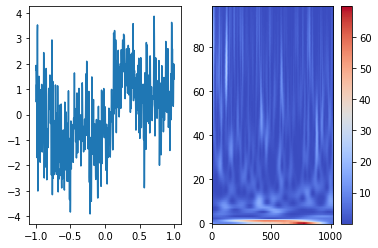

In [15]:
n_samples = 1024
sample_rate = 512
x = np.arange(n_samples) / sample_rate
tmin = -1
tmax = 1
t = np.linspace(tmin, tmax, len(x))
sig = sp.stats.zscore(random_walk(x)) + sp.stats.zscore(band_limited_noise(0, 100, n_samples, samplespacing=1/sample_rate))

freqs = np.arange(1, 100)
cwtmatr = compute_morlet_cwt(sig, x, freqs)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t, sig)

mapable = ax2.imshow(
    normal_rows(cwtmatr),
    # cwtmatr,
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
)
plt.colorbar(mapable, ax=ax2)
plt.show()

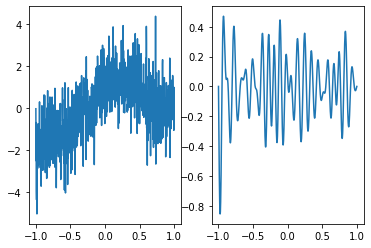

In [416]:
filtered_data = mne.filter.filter_data(sig, sample_rate, 8, 12, verbose=False)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t, sig)

ax2.plot(t, filtered_data)
plt.show()

In [9]:
import tensorflow as tf

y_true = [[0., 1., 0., 1., 7., 3., 4.], [0., 0., 2., 4., 3., 5., 5.]]
y_pred = [[1., 2., 0., 2., 7., 5., 4.], [1., 1., 0., 1., 7., 3., 4.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(y_true, y_true).numpy())
print(mae(y_true, y_pred).numpy())

print('--------')

mse = tf.keras.losses.MeanSquaredError()
print(mse(y_true, y_true).numpy())
print(mse(y_true, y_pred).numpy())


0.0
1.3571429
--------
0.0
3.0714285


In [171]:
alphafirgen = FIRDatasetGenerator(-2, 2, 100, 8, 12)

X, Y = list(), list()

for i in range(1000):

    if not i%100:
        print(i)

    datasample = np.transpose(np.array([
        np.array([x, y])
        for x, y in alphafirgen(64)
    ]), [1, 0, 2])

    x, y = datasample
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

save_pkl((X, Y), '../Source/fir_data_100_8_12Hz.pkl')

0
100
200
300
400
500
600
700
800
900


In [ ]:
model_des = ModelDesign(
    tf.keras.Input(shape=(1, X.shape[2], X.shape[3])),
    tf.keras.layers.DepthwiseConv2D(
        (25, 1),
        padding='SAME',
        depthwise_regularizer='l1',
        # bias_regularizer='l2',
        kernel_regularizer='l2'
    ),
)
model = model_des.build()

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=25)
X_pred = model(X_test)

for i in range(10):
    plot_data_sample(X_test, X_pred, Y_test, i, 1)

In [215]:
X, Y = read_pkl('../Source/fir_data_100_1_4Hz.pkl')
X = np.reshape(X, (64*1000, -1))
Y = np.reshape(Y, (64*1000, -1))

X = np.expand_dims(np.expand_dims(X, 1), 3)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [173]:
X.shape

(64000, 1, 400, 1)

In [174]:
(1, X.shape[2], 1)

(1, 400, 1)

In [177]:
model_des = ModelDesign(
    tf.keras.Input(shape=(1, X.shape[2], 1)),
    tf.keras.layers.Conv2D(
        1,
        (1, 15),
        padding='SAME',
        # bias_regularizer='l2',
        kernel_regularizer='l1'
    ),
    LayerDesign(tf.squeeze)
)
model = model_des.build()
model.compile(optimizer='sgd', loss='mse')
model.fit(X_train, Y_train, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/25
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0593
Epoch 2/25
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0438
Epoch 3/25
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0438
Epoch 4/25
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0438
Epoch 5/25
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0438
Epoch 6/25
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0438


In [ ]:
Y_p = model(X_test).numpy()
for i in range(5):
    sig = np.squeeze(X_test)[i]
    filtered_data = Y_test[i]
    predicted_data = Y_p[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(sig)
    ax1.set_title('Original_signal')
    ax2.plot(filtered_data)
    ax2.set_title('FIR filter 8-12Hz')
    ax3.plot(predicted_data)
    ax3.set_title('Conv2D')
    fig.set_size_inches(15, 5)
    plt.show()

In [ ]:
model_des = ModelDesign(
    tf.keras.Input(shape=(X.shape[2], 1)),
    tf.keras.layers.GRU(
        1,
        kernel_regularizer='l1',
        return_sequences=True,
        recurrent_regularizer='l1',
        bias_regularizer='l1',
    ),
    LayerDesign(tf.squeeze)
)
model = model_des.build()
model.compile(optimizer='sgd', loss='mse')
model.fit(np.squeeze(X_train, axis=1), Y_train, epochs=5, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)], batch_size=100)

In [ ]:
Y_p = model(np.squeeze(X_test, axis=1)).numpy()
for i in range(5):
    sig = np.squeeze(X_test)[i]
    filtered_data = Y_test[i]
    predicted_data = Y_p[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(sig)
    ax1.set_title('Original_signal')
    ax2.plot(filtered_data)
    ax2.set_title('FIR filter 8-12Hz')
    ax3.plot(predicted_data)
    ax3.set_title('Conv2D')
    fig.set_size_inches(15, 5)
    plt.show()

In [5]:
spectralgen = CWTDatasetGenerator(-2, 2, 100)

X, Y = list(), list()

for i, (x, y) in enumerate(spectralgen(10000)):

    if not i%1000:
        print(i)

    # print(x.shape, y.shape)
    # fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax1.plot(spectralgen.times, x)

    # mapable = ax2.imshow(
    #     normal_rows(y),
    #     # cwtmatr,
    #     aspect='auto',
    #     origin='lower',
    #     cmap='coolwarm',
    # )
    # plt.colorbar(mapable, ax=ax2)
    # plt.show()

    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

save_pkl((X, Y), '../Source/cwt_data_100.pkl')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [5]:
X, Y = read_pkl('../Source/cwt_data_100.pkl')
X = np.expand_dims(np.expand_dims(X, 1), 3)
X = X[:X.shape[0]//3, :]
Y = Y[:Y.shape[0]//3, :]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
del X, Y
for Y in [Y_train, Y_test]:
    for i, y in enumerate(Y):
        Y[i] = (y - y.min())/(y.max() - y.min())

In [14]:
model_des = ModelDesign(
    tf.keras.Input((1, X_train.shape[2], 1)),
    tf.keras.layers.Conv2DTranspose(2, (49, 1), kernel_regularizer='l2'),
    tf.keras.layers.Conv2D(1, (10, 10), padding='same'),
    LayerDesign(tf.squeeze)
)
model_des()
model = model_des.build()

model.compile(optimizer='sgd',
            # loss='mse'
            # loss=lambda x, y: 1 - abs(Deploy(tf.image.ssim, max_val=1)(x, y))
            loss=SSIMLoss
)
model.fit(X_train, Y_train, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)], batch_size=100)

Epoch 1/25
25/25 [==============================] - 30s 1s/step - loss: 0.9921
Epoch 2/25
25/25 [==============================] - 30s 1s/step - loss: 0.9879
Epoch 3/25
25/25 [==============================] - 30s 1s/step - loss: 0.9845
Epoch 4/25
25/25 [==============================] - 29s 1s/step - loss: 0.9813
Epoch 5/25
25/25 [==============================] - 31s 1s/step - loss: 0.9771
Epoch 6/25
25/25 [==============================] - 29s 1s/step - loss: 0.9726
Epoch 7/25
25/25 [==============================] - 30s 1s/step - loss: 0.9673
Epoch 8/25
25/25 [==============================] - 31s 1s/step - loss: 0.9609
Epoch 9/25
25/25 [==============================] - 31s 1s/step - loss: 0.9539
Epoch 10/25
25/25 [==============================] - 31s 1s/step - loss: 0.9456
Epoch 11/25
25/25 [==============================] - 30s 1s/step - loss: 0.9360
Epoch 12/25
25/25 [==============================] - 31s 1s/step - loss: 0.9250
Epoch 13/25
25/25 [==============================

In [11]:


Y_p = model(X_test).numpy()

for i in range(5):
    plot_predicted_CWT(Y_test[i], Y_p[i])

2022-06-10 11:21:41.847645: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 653856000 exceeds 10% of free system memory.
2022-06-10 11:21:42.217687: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 653856000 exceeds 10% of free system memory.


: 

: 

In [6]:
model_des = ModelDesign(
    tf.keras.Input((1, X_train.shape[2], 1)),
    tf.keras.layers.Conv2D(100, (1, 15), padding='SAME', kernel_regularizer='l1'),
    # LayerDesign(tf.squeeze),
    LayerDesign(tf.transpose, [0, 3, 2, 1]),
    tf.keras.layers.Conv2D(49, (100, 1), padding='VALID',  kernel_regularizer='l1'),
    LayerDesign(tf.squeeze),
    LayerDesign(tf.transpose, [0, 2, 1]),
)
# model_des()
model = model_des.build()
model.compile(optimizer='adam', loss=SSIMLoss)#loss='mse')
model.fit(X_train, Y_train, epochs=25, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)], batch_size=100)

2022-06-10 11:23:54.302098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-10 11:23:54.302156: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 11:23:54.302193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-06-10 11:23:54.302631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
25/25 [==============================] - 8s 254ms/step - loss: 1.6222
Epoch 2/25
25/25 [==============================] - 5s 193ms/step - loss: 0.9312
Epoch 3/25
25/25 [==============================] - 5s 199ms/step - loss: 0.7949
Epoch 4/25
25/25 [==============================] - 5s 193ms/step - loss: 0.7755
Epoch 5/25
25/25 [==============================] - 5s 197ms/step - loss: 0.7740
Epoch 6/25
25/25 [==============================] - 5s 207ms/step - loss: 0.7701
Epoch 7/25
25/25 [==============================] - 5s 214ms/step - loss: 0.7717
Epoch 8/25
25/25 [==============================] - 5s 215ms/step - loss: 0.7715
Epoch 9/25
25/25 [==============================] - 5s 202ms/step - loss: 0.7718


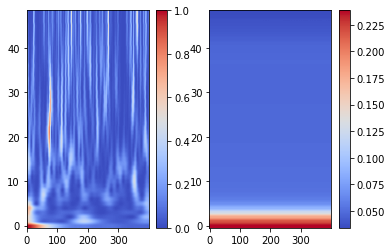

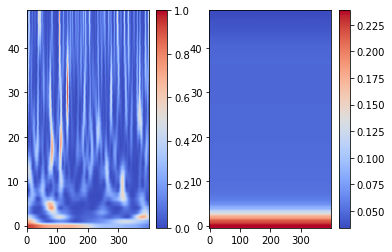

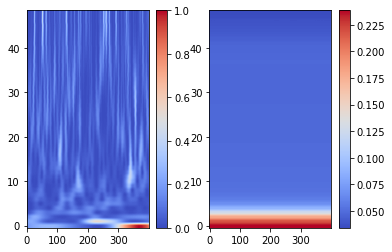

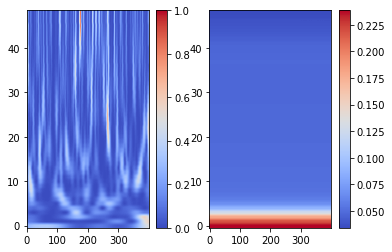

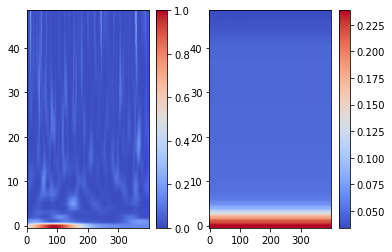

In [9]:

Y_p = model(X_test).numpy()

for i in range(5):
    plot_predicted_CWT(Y_test[i], Y_p[i])